# Jupyter notebook de avaliação dos dados da produção da Brazilian FISH

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xlsxwriter
from tabulate import tabulate
import seaborn as sns

#from google.colab import drive
#from electre_tree import tree_e_tri_b , util_e_tri_b
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
#from yellowbrick.cluster import KElbowVisualizer
#from yellowbrick.cluster import SilhouetteVisualizer
# Required Libraries
import os


In [2]:
dataset = pd.DataFrame()
file = pd.ExcelFile('data\C_DADOS_BZF.xlsx')
sheets_list = ['Produção', 'Industria', 'Descrição']
for sheet in sheets_list:
    if 'Descrição' != sheet:
        temp_df = pd.read_excel(file, sheet_name=sheet)
        dataset = pd.concat([dataset, temp_df])
first_list = temp_df.columns.tolist()
temp_df = dataset.reset_index(drop=True)
#dataset.head()
len(dataset)

4504

In [3]:
xls = pd.ExcelFile('data\C_DADOS_BZF.xlsx')
prod= pd.read_excel(xls, 'Produção')
ind= pd.read_excel(xls, 'Industria')

In [4]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970 entries, 0 to 1969
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID Lote                          1970 non-null   int64         
 1   Unidade                          1970 non-null   object        
 2   Tanque                           1970 non-null   object        
 3   Fase                             1970 non-null   object        
 4   Tamanho                          1970 non-null   object        
 5   Lote                             1970 non-null   object        
 6    nº Dias                         1970 non-null   int64         
 7   Peso Médio Inicial               1970 non-null   float64       
 8    Data Entrada                    1970 non-null   datetime64[ns]
 9    Data Encerramento               1970 non-null   object        
 10   Saldo                           1970 non-null   int64      

In [5]:
for col in prod.columns:
    print(col)

ID Lote
Unidade
Tanque
Fase
Tamanho
Lote
 nº Dias
Peso Médio Inicial
 Data Entrada
 Data Encerramento
 Saldo
 Quantidade Inicial
 Mortalidade
 Mortalidade Coletada
 Sobrevivência
 Saldo Final
 Outras Saídas
 Curva
 Peso Médio Saída
 Peso Médio Entrada 
Biomassa Final
 Biomassa Inicial
Biomassa Ganha
Status
Data Despesca
 Peso Médio Despesca
 Biomassa Despesca
 Espécie
 Tipo Tanque
 GPD Fase
GPD Real
 Peso Médio Atual
 Biomassa Atual
 Peso Médio Biometria
 Biomassa Biometria
 Densidade Máxima
 Metragem Tanque
 Conversão Alimentar
 Conversão Acumulada
 Custo Total Entrada (Biomassa)
 Custo Total Entrada (Peixe)
 Custo Entrada/Kg
 Custo Entrada/Unidades
Custo Ração
 Custo Insumos
 Custo Alevinos
Custo Indireto
Custos Totais (Peixe)
Custos Totais (Biomassa)
Custo/Kg
Custo/Peixe
Últ. Biometria
Peso Médio Últ. Biometria
Peso Estimado Biometria
Densidade
Ração Nominal
Ração Real
 % Nominal/Real
 Linha
 Sequência
 Produto Origem
Fornecedor Origem
 Data Povoamento


In [6]:
## Eliminar espacos dos nomes das colunas
prod.columns = prod.columns.str.strip()

In [7]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970 entries, 0 to 1969
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID Lote                         1970 non-null   int64         
 1   Unidade                         1970 non-null   object        
 2   Tanque                          1970 non-null   object        
 3   Fase                            1970 non-null   object        
 4   Tamanho                         1970 non-null   object        
 5   Lote                            1970 non-null   object        
 6   nº Dias                         1970 non-null   int64         
 7   Peso Médio Inicial              1970 non-null   float64       
 8   Data Entrada                    1970 non-null   datetime64[ns]
 9   Data Encerramento               1970 non-null   object        
 10  Saldo                           1970 non-null   int64         
 11  Quan

In [8]:
prod.select_dtypes(include='number').head()

,ID Lote,nº Dias,Peso Médio Inicial,Saldo,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Outras Saídas,...,Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Peso Médio Últ. Biometria,Peso Estimado Biometria,Densidade,Ração Nominal,Ração Real,% Nominal/Real,Sequência
0,7201,85,46.0,0,8089,2254,204,72.184448,5839,0,...,19125.523013,7.737645,4.112011,NaN,NaN,NaN,5279.906040,4239.251772,80.290288,6
1,7202,63,84.0,0,8176,1549,235,81.054305,6627,0,...,19979.966837,6.981896,3.415351,NaN,NaN,NaN,4359.112894,3821.237976,87.660909,7
2,7203,45,188.0,0,8516,1307,98,84.652419,7209,0,...,21469.799126,7.118032,2.457712,NaN,NaN,NaN,3704.695446,2902.144641,78.336929,13
3,7206,63,80.0,0,8152,1590,157,80.495584,6562,0,...,19860.435832,7.318226,3.474131,NaN,NaN,NaN,4298.687760,3828.892759,89.071200,0
4,7207,63,590.0,0,8100,328,328,96.604938,7825,0,...,57577.926096,8.175779,9.615427,NaN,NaN,NaN,6845.448715,6354.039134,92.821368,15


In [9]:
prod_num=prod.select_dtypes(include='number')
prod_num.isnull().sum().sort_values(ascending=False)


Peso Estimado Biometria           1722
Biomassa Biometria                1720
Peso Médio Últ. Biometria         1720
Peso Médio Biometria              1720
Biomassa Despesca                 1703
Peso Médio Despesca               1703
Densidade                         1703
Peso Médio Atual                  1703
Custo Alevinos                      26
Custo Ração                         26
Custo Insumos                       26
Custo/Kg                            26
Custos Totais (Peixe)               26
Custos Totais (Biomassa)            26
Custo/Peixe                         26
Ração Real                          26
% Nominal/Real                      26
GPD Real                            21
Ração Nominal                       20
Conversão Alimentar                  6
Custo Entrada/Unidades               0
Custo Total Entrada (Biomassa)       0
Custo Indireto                       0
Custo Entrada/Kg                     0
Custo Total Entrada (Peixe)          0
ID Lote                  

In [10]:
#prod.select_dtypes(include='datatimelike').headh()

In [11]:
prod.select_dtypes(include='object').head()

,Unidade,Tanque,Fase,Tamanho,Lote,Data Encerramento,Curva,Status,Espécie,Tipo Tanque,Linha,Produto Origem,Fornecedor Origem
0,Unidade 3,TR111,Fase 3,P,L055-VAC,2022-03-29 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 10,Avulsa,Avulsa
1,Unidade 3,TR142,Fase 3,M,L055-VAC,2022-03-07 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 09,Avulsa,Avulsa
2,Unidade 3,TR254,Fase 3,G,L055-VAC,2022-02-17 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 03,Avulsa,Avulsa
3,Unidade 3,TR123,Fase 3,M,L057-VAC,2022-03-08 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,NaN,Avulsa,Avulsa
4,Unidade 3,TR670,Fase 4,G,L048-VAC,2022-03-08 00:00:00,F4 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 07,Avulsa,Avulsa


In [12]:
prod_cat=prod.select_dtypes(include='object')
prod_cat.isnull().sum().sort_values(ascending=False)


Linha                474
Unidade                0
Tanque                 0
Fase                   0
Tamanho                0
Lote                   0
Data Encerramento      0
Curva                  0
Status                 0
Espécie                0
Tipo Tanque            0
Produto Origem         0
Fornecedor Origem      0
dtype: int64

In [13]:
prod_num = prod_num.drop(columns=[
'Peso Estimado Biometria',
'Biomassa Biometria',
'Peso Médio Últ. Biometria',
'Peso Médio Biometria',
'Biomassa Despesca',
'Peso Médio Despesca',
'Densidade',
'Peso Médio Atual',
])

prod_num.head()

,ID Lote,nº Dias,Peso Médio Inicial,Saldo,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Outras Saídas,...,Custo Alevinos,Custo Indireto,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Ração Nominal,Ração Real,% Nominal/Real,Sequência
0,7201,85,46.0,0,8089,2254,204,72.184448,5839,0,...,0.0,0,24010.032110,19125.523013,7.737645,4.112011,5279.906040,4239.251772,80.290288,6
1,7202,63,84.0,0,8176,1549,235,81.054305,6627,0,...,0.0,0,22633.531848,19979.966837,6.981896,3.415351,4359.112894,3821.237976,87.660909,7
2,7203,45,188.0,0,8516,1307,98,84.652419,7209,0,...,0.0,0,17717.644222,21469.799126,7.118032,2.457712,3704.695446,2902.144641,78.336929,13
3,7206,63,80.0,0,8152,1590,157,80.495584,6562,0,...,0.0,0,22797.248557,19860.435832,7.318226,3.474131,4298.687760,3828.892759,89.071200,0
4,7207,63,590.0,0,8100,328,328,96.604938,7825,0,...,0.0,0,75240.713679,57577.926096,8.175779,9.615427,6845.448715,6354.039134,92.821368,15


In [14]:
prod_num1=prod_num.iloc[:,:-20]

prod_num2=prod_num.iloc[:,-20:]

In [15]:
#prod_1=prod_num['Peso Médio Inicial', 'Saldo', 'Quantidade Inicial', 'Mortalidade', 'Mortalidade Coletada', 'Sobrevivência', 'Saldo Final',
#'Outras Saídas', 'Peso Médio Saída', 'Peso Médio Entrada', 'Biomassa Final', 'Biomassa Inicial', 'Biomassa Ganha', 'GPD Fase', 'GPD Real' 'Biomassa Atual','Conversão Alimentar', 'Conversão Acumulada',]

#prod_2=prod_num['ID Lote', 'nº Dias','Densidade Máxima', 'Metragem Tanque', 'Custo Total Entrada (Biomassa)','Custo Total Entrada (Peixe)', 
#'Custo Entrada/Kg', 'Custo Entrada/Unidades', 'Custo Ração', 'Custo Insumos', 'Custo Alevinos', 'Custo Indireto',
#'Custos Totais (Peixe)', 'Custos Totais (Biomassa)', 'Custo/Kg', 'Custo/Peixe', 'Ração Nominal', 'Ração Real', '% Nominal/Real', 'Sequência']



# Separei o df de vairáveis numéricas em dois df menores 
### prod_num1 com as seguintes colunas:  
'ID Lote', 'nº Dias', 'Peso Médio Inicial', 'Saldo', 'Quantidade Inicial', 'Mortalidade', 'Mortalidade Coletada', 'Sobrevivência', 'Saldo Final',

'Outras Saídas',  'Peso Médio Saída',  'Peso Médio Entrada', 'Biomassa Final', 'Biomassa Inicial', 'Biomassa Ganha', 'GPD Fase', 'GPD Real' 'Biomassa Atual', 

### prod_num2 com as seguintes colunas:
'Densidade Máxima', 'Metragem Tanque', 'Custo Total Entrada (Biomassa)', 'Conversão Alimentar', 'Conversão Acumulada',

'Custo Total Entrada (Peixe)', 'Custo Entrada/Kg', 'Custo Entrada/Unidades', 'Custo Ração', 'Custo Insumos', 'Custo Alevinos', 'Custo Indireto',

'Custos Totais (Peixe)', 'Custos Totais (Biomassa)', 'Custo/Kg', 'Custo/Peixe', 'Ração Nominal', 'Ração Real', '% Nominal/Real', 'Sequência'

In [16]:
prod_num1.isnull().sum().sort_values(ascending=False)

GPD Real                21
ID Lote                  0
nº Dias                  0
GPD Fase                 0
Biomassa Ganha           0
Biomassa Inicial         0
Biomassa Final           0
Peso Médio Entrada       0
Peso Médio Saída         0
Outras Saídas            0
Saldo Final              0
Sobrevivência            0
Mortalidade Coletada     0
Mortalidade              0
Quantidade Inicial       0
Saldo                    0
Peso Médio Inicial       0
Biomassa Atual           0
dtype: int64

In [17]:
prod_num2.isnull().sum().sort_values(ascending=False)

Custo Alevinos                    26
Custos Totais (Peixe)             26
% Nominal/Real                    26
Ração Real                        26
Custo/Peixe                       26
Custo/Kg                          26
Custo Ração                       26
Custo Insumos                     26
Custos Totais (Biomassa)          26
Ração Nominal                     20
Conversão Alimentar                6
Densidade Máxima                   0
Custo Indireto                     0
Metragem Tanque                    0
Custo Entrada/Unidades             0
Custo Entrada/Kg                   0
Custo Total Entrada (Peixe)        0
Custo Total Entrada (Biomassa)     0
Conversão Acumulada                0
Sequência                          0
dtype: int64

In [18]:
prod_num1.describe()

,ID Lote,nº Dias,Peso Médio Inicial,Saldo,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Outras Saídas,Peso Médio Saída,Peso Médio Entrada,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real,Biomassa Atual
count,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.0,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1949.000000,1970.000000
mean,12028.802030,61.274112,186.776182,1101.360406,9925.903553,1261.706091,439.596954,90.758724,7776.413706,0.0,441.688276,187.185120,3309.708620,1465.534125,2312.983966,4.753884,4.795840,468.809472
std,2958.463803,28.137459,170.384487,2894.039886,4847.708295,1985.653598,723.588693,17.701486,5303.292947,0.0,368.227591,170.557982,2793.264602,1311.600219,1539.723524,2.303407,2.072655,1440.801597
min,7201.000000,0.000000,11.000000,0.000000,886.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,11.000000,0.000000,32.782000,-3921.736000,-21.326102,0.363244,0.000000
25%,8841.500000,42.000000,40.025000,0.000000,8042.000000,103.250000,58.000000,82.888889,5546.000000,0.0,78.115685,40.016005,1214.515000,451.378250,1245.444500,3.188514,3.249471,0.000000
50%,12794.500000,62.000000,98.000000,0.000000,8109.000000,501.500000,185.500000,94.452426,7405.000000,0.0,359.833872,97.978292,2398.604000,774.594000,1917.513500,4.848853,4.860397,0.000000
75%,14554.500000,79.000000,350.000000,0.000000,9032.750000,1504.500000,523.000000,99.962553,8684.500000,0.0,844.000000,350.198823,6150.918000,2626.129100,3280.948425,6.493929,6.472949,0.000000
max,16349.000000,172.000000,1080.000000,21663.000000,27825.000000,14090.000000,7095.000000,260.233333,36485.000000,0.0,1173.814607,1080.000000,11395.024000,5811.582600,8246.090000,23.083241,11.666667,8064.924769


In [19]:
prod_num2.describe()

,Densidade Máxima,Metragem Tanque,Conversão Alimentar,Conversão Acumulada,Custo Total Entrada (Biomassa),Custo Total Entrada (Peixe),Custo Entrada/Kg,Custo Entrada/Unidades,Custo Ração,Custo Insumos,Custo Alevinos,Custo Indireto,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Ração Nominal,Ração Real,% Nominal/Real,Sequência
count,1970.000000,1970.000000,1964.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1944.000000,1944.0,1944.0,1970.0,1944.000000,1944.000000,1944.000000,1944.000000,1950.000000,1944.000000,1944.000000,1970.000000
mean,3.408122,80.643655,1.718896,1.579711,8032.961144,8130.641681,6.192288,1.027134,12821.598737,0.0,0.0,0.0,21051.480161,20952.615508,5.695674,2.803107,4265.515296,4093.698176,90.862037,8.776142
std,16.374767,41.139895,2.222996,2.196658,7575.670729,7521.624594,2.434567,1.030200,8338.998050,0.0,0.0,0.0,14404.178576,14347.713385,1.344970,1.959483,2742.098912,2970.609006,15.237869,7.453812
min,0.000000,16.000000,0.000000,-25.249060,0.000000,0.000000,0.000000,0.000000,27.150000,0.0,0.0,0.0,27.150000,27.150000,0.042338,0.002975,2.130830,6.000000,8.218430,0.000000
25%,0.000000,56.000000,1.423276,1.329820,2818.804594,2973.948076,5.261855,0.225120,6630.727143,0.0,0.0,0.0,10196.953637,10151.839715,5.009704,1.425976,2289.948608,1956.514731,82.359245,1.000000
50%,0.000000,56.000000,1.649346,1.547696,4589.302908,4496.195787,6.187961,0.494480,11134.498337,0.0,0.0,0.0,15737.256810,15761.359563,5.560850,2.287665,3816.136112,3487.241569,92.043059,8.000000
75%,0.000000,126.000000,1.828513,1.760720,13195.828478,13262.236535,7.272453,1.847713,18089.198870,0.0,0.0,0.0,31619.078538,31221.820338,6.369581,4.273909,6081.454130,5961.781057,100.470673,15.000000
max,90.000000,144.000000,72.116385,65.140703,37328.595512,61690.731177,14.607578,7.599252,39482.437874,0.0,0.0,0.0,85809.043357,66969.591318,11.543820,11.555217,13022.443541,13950.959383,151.841120,27.000000


#################### KEEEEEEEP GOING

In [20]:
prod_num2.groupby(by = ['Custo Insumos'], as_index = False).size()

,Custo Insumos,size
0,0.0,1944


In [21]:
prod_num2.groupby(by = ['Custo Alevinos'], as_index = False).size()


,Custo Alevinos,size
0,0.0,1944


In [22]:
prod_num2.groupby(by = ['Custo Indireto'], as_index = False).size()


,Custo Indireto,size
0,0,1970


In [23]:
prod_num2.groupby(by = ['Densidade Máxima'], as_index = False).size()


,Densidade Máxima,size
0,0,1888
1,80,63
2,84,6
3,90,13


In [24]:
prod_num2 = prod_num2.drop(columns=[
'Custo Insumos',
'Custo Alevinos',
'Custo Indireto',
'Densidade Máxima', 
'Sequência'
])

prod_num2.describe()

,Metragem Tanque,Conversão Alimentar,Conversão Acumulada,Custo Total Entrada (Biomassa),Custo Total Entrada (Peixe),Custo Entrada/Kg,Custo Entrada/Unidades,Custo Ração,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Ração Nominal,Ração Real,% Nominal/Real
count,1970.000000,1964.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1950.000000,1944.000000,1944.000000
mean,80.643655,1.718896,1.579711,8032.961144,8130.641681,6.192288,1.027134,12821.598737,21051.480161,20952.615508,5.695674,2.803107,4265.515296,4093.698176,90.862037
std,41.139895,2.222996,2.196658,7575.670729,7521.624594,2.434567,1.030200,8338.998050,14404.178576,14347.713385,1.344970,1.959483,2742.098912,2970.609006,15.237869
min,16.000000,0.000000,-25.249060,0.000000,0.000000,0.000000,0.000000,27.150000,27.150000,27.150000,0.042338,0.002975,2.130830,6.000000,8.218430
25%,56.000000,1.423276,1.329820,2818.804594,2973.948076,5.261855,0.225120,6630.727143,10196.953637,10151.839715,5.009704,1.425976,2289.948608,1956.514731,82.359245
50%,56.000000,1.649346,1.547696,4589.302908,4496.195787,6.187961,0.494480,11134.498337,15737.256810,15761.359563,5.560850,2.287665,3816.136112,3487.241569,92.043059
75%,126.000000,1.828513,1.760720,13195.828478,13262.236535,7.272453,1.847713,18089.198870,31619.078538,31221.820338,6.369581,4.273909,6081.454130,5961.781057,100.470673
max,144.000000,72.116385,65.140703,37328.595512,61690.731177,14.607578,7.599252,39482.437874,85809.043357,66969.591318,11.543820,11.555217,13022.443541,13950.959383,151.841120


In [25]:
prod_num2.groupby(by = ['Conversão Alimentar'], as_index = False).size()


,Conversão Alimentar,size
0,0.000000,22
1,0.217252,1
2,0.267367,1
3,0.334177,1
4,0.405716,1
...,...,...
1938,3.962618,1
1939,4.515163,1
1940,13.779609,1
1941,65.678321,1


In [26]:
prod_num2.groupby(by = ['Custo Total Entrada (Biomassa)','Custo Total Entrada (Peixe)','Custo Entrada/Kg','Custo Entrada/Unidades'], as_index = False).size()

,Custo Total Entrada (Biomassa),Custo Total Entrada (Peixe),Custo Entrada/Kg,Custo Entrada/Unidades,size
0,0.000000,0.000000,0.000000,0.000000,144
1,136.439000,136.439000,0.191381,0.074638,1
2,294.613781,2244.475999,5.859230,0.492318,1
3,356.844298,2379.419056,4.377008,0.361889,1
4,396.000524,2426.750584,7.420048,0.574651,1
...,...,...,...,...,...
1627,33480.346446,29818.529283,6.739001,3.549825,1
1628,33486.887231,27941.625896,6.129206,3.266498,1
1629,34322.662444,30482.458019,6.894420,3.711941,1
1630,35715.251910,53378.039494,7.561200,6.589881,1


In [27]:
prod_num2 =prod_num2[prod_num2['Custo Entrada/Kg'] != 0]
prod_num2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1943
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Metragem Tanque                 1826 non-null   float64
 1   Conversão Alimentar             1826 non-null   float64
 2   Conversão Acumulada             1826 non-null   float64
 3   Custo Total Entrada (Biomassa)  1826 non-null   float64
 4   Custo Total Entrada (Peixe)     1826 non-null   float64
 5   Custo Entrada/Kg                1826 non-null   float64
 6   Custo Entrada/Unidades          1826 non-null   float64
 7   Custo Ração                     1824 non-null   float64
 8   Custos Totais (Peixe)           1824 non-null   float64
 9   Custos Totais (Biomassa)        1824 non-null   float64
 10  Custo/Kg                        1824 non-null   float64
 11  Custo/Peixe                     1824 non-null   float64
 12  Ração Nominal                   18

## Eliminar as 144 linhas por não ter informações importantes de custo.

### Selecionar linhas de limpeza e add em ETL_BZF_prod

In [28]:
prod_num1.groupby(by = ['Outras Saídas'], as_index = False).size()

,Outras Saídas,size
0,0,1970


In [29]:
prod_num1.groupby(by = ['Biomassa Atual'], as_index = False).size()


,Biomassa Atual,size
0,0.000000,1703
1,32.782000,1
2,102.750429,1
3,190.357658,1
4,249.881533,1
...,...,...
263,7712.432490,1
264,7722.780773,1
265,7860.974008,1
266,7882.882315,1


In [30]:
prod_num1.groupby(by = ['Saldo'], as_index = False).size()


,Saldo,size
0,0,1703
1,886,1
2,2655,1
3,3552,1
4,3555,1
...,...,...
240,14739,1
241,19611,1
242,19711,1
243,21427,1


In [31]:
prod_num1 = prod_num1.drop(columns=[
'Outras Saídas',
'Biomassa Atual', 
'Saldo'                 
])

prod_num1.describe()

,ID Lote,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real
count,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1970.000000,1949.000000
mean,12028.802030,61.274112,186.776182,9925.903553,1261.706091,439.596954,90.758724,7776.413706,441.688276,187.185120,3309.708620,1465.534125,2312.983966,4.753884,4.795840
std,2958.463803,28.137459,170.384487,4847.708295,1985.653598,723.588693,17.701486,5303.292947,368.227591,170.557982,2793.264602,1311.600219,1539.723524,2.303407,2.072655
min,7201.000000,0.000000,11.000000,886.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,32.782000,-3921.736000,-21.326102,0.363244
25%,8841.500000,42.000000,40.025000,8042.000000,103.250000,58.000000,82.888889,5546.000000,78.115685,40.016005,1214.515000,451.378250,1245.444500,3.188514,3.249471
50%,12794.500000,62.000000,98.000000,8109.000000,501.500000,185.500000,94.452426,7405.000000,359.833872,97.978292,2398.604000,774.594000,1917.513500,4.848853,4.860397
75%,14554.500000,79.000000,350.000000,9032.750000,1504.500000,523.000000,99.962553,8684.500000,844.000000,350.198823,6150.918000,2626.129100,3280.948425,6.493929,6.472949
max,16349.000000,172.000000,1080.000000,27825.000000,14090.000000,7095.000000,260.233333,36485.000000,1173.814607,1080.000000,11395.024000,5811.582600,8246.090000,23.083241,11.666667


In [32]:
prod_num1.groupby(by = ['nº Dias'], as_index = False).size()


,nº Dias,size
0,0,21
1,1,5
2,2,4
3,3,5
4,4,3
...,...,...
134,153,1
135,158,1
136,159,1
137,162,1


In [33]:
prod_num1.groupby(by = ['Sobrevivência'], as_index = False).size()

,Sobrevivência,size
0,0.000000,20
1,22.918756,1
2,28.651070,1
3,30.400000,1
4,40.410326,1
...,...,...
1909,159.441667,1
1910,160.747511,1
1911,163.833851,1
1912,166.161473,1


In [34]:
prod_num1.groupby(by = ['Saldo Final'], as_index = False).size()


,Saldo Final,size
0,0,286
1,1828,1
2,2224,1
3,2623,1
4,2662,1
...,...,...
1472,27252,1
1473,27706,1
1474,28263,1
1475,34669,1


In [35]:
prod_num1.groupby(by = ['Saldo Final','Peso Médio Saída','Biomassa Final'], as_index = False).size()


,Saldo Final,Peso Médio Saída,Biomassa Final,size
0,0,0.000000,0.0000,286
1,1828,390.000000,712.9200,1
2,2224,492.919964,1096.2540,1
3,2623,321.139154,842.3480,1
4,2662,355.843727,947.2560,1
...,...,...,...,...
1670,27252,87.029539,2371.7290,1
1671,27706,73.762109,2043.6530,1
1672,28263,70.020100,1978.9781,1
1673,34669,67.599094,2343.5930,1


In [36]:
#prod_num1.groupby(by = ['Biomassa Final'], as_index = False).size()



In [37]:
prod_num1 =prod_num1[prod_num1['Saldo Final'] != 0]
prod_num1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 0 to 1920
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID Lote               1684 non-null   int64  
 1   nº Dias               1684 non-null   int64  
 2   Peso Médio Inicial    1684 non-null   float64
 3   Quantidade Inicial    1684 non-null   int64  
 4   Mortalidade           1684 non-null   int64  
 5   Mortalidade Coletada  1684 non-null   int64  
 6   Sobrevivência         1684 non-null   float64
 7   Saldo Final           1684 non-null   int64  
 8   Peso Médio Saída      1684 non-null   float64
 9   Peso Médio Entrada    1684 non-null   float64
 10  Biomassa Final        1684 non-null   float64
 11  Biomassa Inicial      1684 non-null   float64
 12  Biomassa Ganha        1684 non-null   float64
 13  GPD Fase              1684 non-null   float64
 14  GPD Real              1684 non-null   float64
dtypes: float64(9), int64(

In [48]:
prod_num1.describe()

,ID Lote,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real
count,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000
mean,11472.783254,63.949525,185.966673,10197.805226,1426.358670,464.627672,90.937064,9097.111045,516.701843,186.182412,3871.808777,1463.789764,2410.541596,4.795260,4.779965
std,2751.784530,26.756341,172.668118,5069.407910,2097.390254,762.424886,16.133897,4569.753218,346.194429,172.811863,2636.394382,1332.419488,1516.065220,2.124048,2.073951
min,7201.000000,3.000000,11.000000,2249.000000,0.000000,0.000000,22.918756,1828.000000,35.694716,11.000000,225.063000,50.282000,-2118.560000,0.388241,0.388241
25%,8559.750000,45.750000,39.692500,8045.000000,147.750000,70.000000,81.573963,6695.500000,303.926137,39.714892,1917.368250,456.313135,1337.470550,3.278400,3.248455
50%,12353.000000,63.000000,95.000000,8130.000000,658.000000,200.500000,93.312682,7724.500000,397.914182,94.932000,2730.035000,766.262000,2010.956100,4.890711,4.876964
75%,13900.000000,82.000000,356.000000,9081.750000,1730.750000,529.000000,100.680405,9292.500000,866.000000,360.220919,6789.623000,2682.000000,3295.906750,6.397414,6.373735
max,16124.000000,172.000000,656.000000,27825.000000,14090.000000,7095.000000,260.233333,36485.000000,1173.814607,638.706453,11395.024000,5811.582600,8246.090000,21.704905,11.666667


In [49]:
prod_num2.describe()

,Metragem Tanque,Conversão Alimentar,Conversão Acumulada,Custo Total Entrada (Biomassa),Custo Total Entrada (Peixe),Custo Entrada/Kg,Custo Entrada/Unidades,Custo Ração,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Ração Nominal,Ração Real,% Nominal/Real
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000
mean,79.816813,1.744443,1.595970,8666.447675,8771.831387,6.680617,1.108135,12641.733688,21413.054679,21307.685773,5.885718,2.831776,4218.010567,4022.963746,90.932135
std,40.914179,2.296403,2.272956,7511.728817,7443.878948,1.769367,1.027251,8200.825323,14583.565289,14526.719602,1.108536,1.989787,2684.400261,2932.065823,14.297199
min,16.000000,0.000000,-25.249060,136.439000,136.439000,0.191381,0.063555,257.140000,2283.031716,1430.079734,1.972212,0.119324,200.771269,94.600000,34.866183
25%,56.000000,1.425143,1.328649,3217.812155,3296.145790,5.420981,0.294483,6637.867670,10242.291180,10184.539662,5.088667,1.439945,2348.269400,1951.865295,82.095687
50%,56.000000,1.643827,1.540312,4860.495464,4836.002426,6.318223,0.555649,10697.162934,15794.240908,15857.252249,5.635355,2.245520,3740.345905,3378.480695,91.422072
75%,126.000000,1.841599,1.755350,14108.332376,13767.124106,7.370125,1.910617,17650.456387,32852.859678,33854.782952,6.429954,4.400480,5973.027267,5867.614558,100.581656
max,144.000000,72.116385,65.140703,37328.595512,61690.731177,14.607578,7.599252,39482.437874,85809.043357,66969.591318,11.543820,11.555217,13022.443541,13950.959383,137.726748


<Axes: >

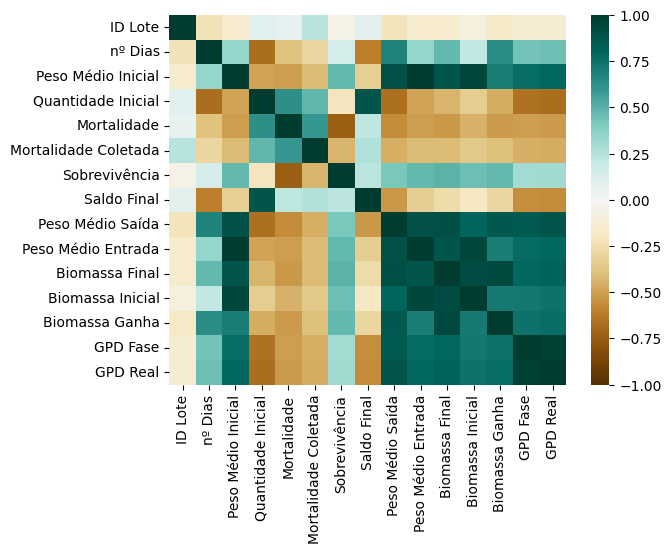

In [38]:
sns.heatmap(prod_num1.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

<Axes: >

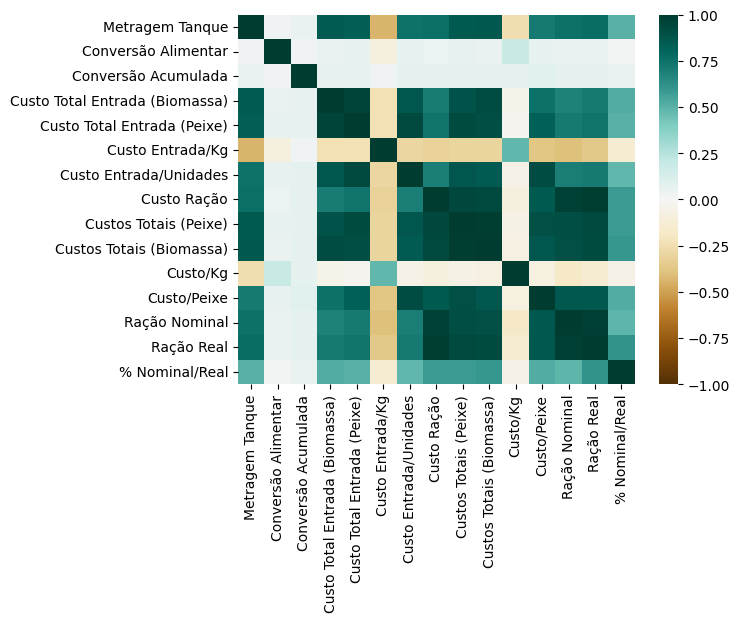

In [39]:
sns.heatmap(prod_num2.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

In [47]:
m = pd.merge(prod_num1, prod_num2, how = 'outer', on = 'ID Lote')
m.info()

KeyError: 'ID Lote'

In [40]:
for col in prod_num2.columns:
    print(col)

Metragem Tanque
Conversão Alimentar
Conversão Acumulada
Custo Total Entrada (Biomassa)
Custo Total Entrada (Peixe)
Custo Entrada/Kg
Custo Entrada/Unidades
Custo Ração
Custos Totais (Peixe)
Custos Totais (Biomassa)
Custo/Kg
Custo/Peixe
Ração Nominal
Ração Real
% Nominal/Real


In [41]:
num_list = ['Metragem Tanque',
'Custo Total Entrada (Biomassa)',
'Custo Total Entrada (Peixe)',
'Custo Entrada/Kg',
'Custo Entrada/Unidades',
'Custo Ração',
'Custos Totais (Peixe)',
'Custos Totais (Biomassa)',
'Custo/Kg',
'Custo/Peixe',
'Ração Nominal',
'Ração Real',
'% Nominal/Real'
]

<Axes: >

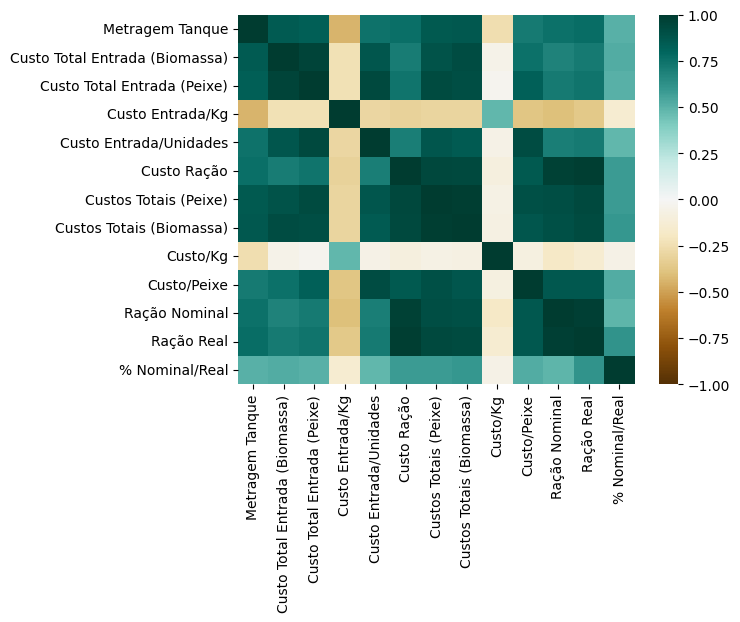

In [42]:
#ind_new = ind[num_list]
temp_df = prod_num2.reset_index(drop=True)
temp_df = prod_num2[num_list]
sns.heatmap(temp_df.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

In [43]:
for col in prod_num1.columns:
    print(col)

ID Lote
nº Dias
Peso Médio Inicial
Quantidade Inicial
Mortalidade
Mortalidade Coletada
Sobrevivência
Saldo Final
Peso Médio Saída
Peso Médio Entrada
Biomassa Final
Biomassa Inicial
Biomassa Ganha
GPD Fase
GPD Real


In [44]:
num_list = ['ID Lote',
'nº Dias',
'Peso Médio Inicial',
'Quantidade Inicial',
'Mortalidade',
'Mortalidade Coletada',
'Sobrevivência',
'Saldo Final',
'Peso Médio Saída',
'Peso Médio Entrada',
'Biomassa Final',
'Biomassa Inicial',
'Biomassa Ganha',
'GPD Fase',
'GPD Real',
'Conversão Alimentar',
'Conversão Acumulada']

<Axes: >

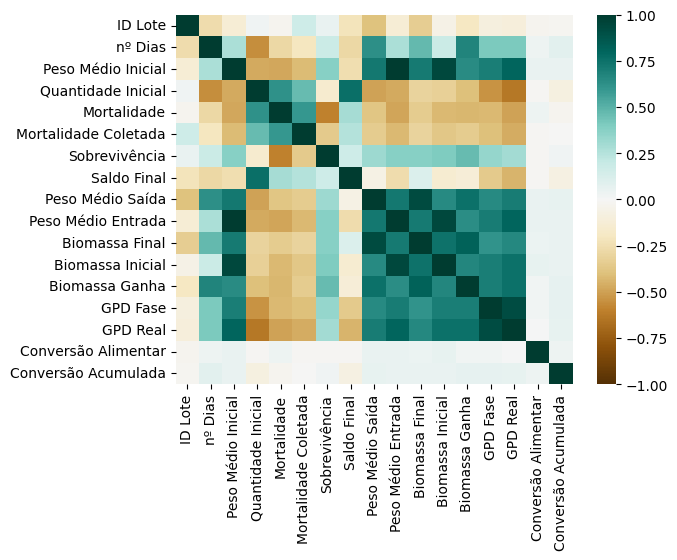

In [45]:
#ind_new = ind[num_list]
temp_df = prod_num1.reset_index(drop=True)
temp_df = prod_num[num_list]
sns.heatmap(temp_df.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

### keep going from here

# Separate into economic e zootecnic variables

In [46]:
dados = prod_desc.copy()

tabela = tabulate(dados, headers="firstrow", tablefmt="sheet")

#dados.to_excel('data/prod_describe.xlsx', index = False)

NameError: name 'prod_desc' is not defined

In [ ]:
dados = ind_desc.copy()

tabela = tabulate(dados, headers="firstrow", tablefmt="sheet")

#dados.to_excel('data/ind_describe.xlsx', index = False)

In [ ]:
#data[['Pclass','Sex']].value_counts()
#data.sort_values(by='Age',ascending=False)



In [ ]:
num_list = ['Peso Médio Inicial',
' Quantidade Inicial',
' Mortalidade',
' Mortalidade Coletada',
' Sobrevivência',
' Peso Médio Saída',
' Peso Médio Entrada ',
'Biomassa Final',
' Biomassa Inicial',
'Biomassa Ganha',
' GPD Fase',
'GPD Real',
' Conversão Alimentar',
' Conversão Acumulada',
' Custo Total Entrada (Biomassa)',
' Custo Total Entrada (Peixe)',
' Custo Entrada/Kg',
' Custo Entrada/Unidades',
'Custo Ração',
'Custos Totais (Peixe)',
'Custos Totais (Biomassa)',
'Custo/Kg',
'Custo/Peixe',
'Ração Nominal',
'Ração Real',
' % Nominal/Real'
]

In [ ]:
#ind_new = ind[num_list]
temp_df = temp_df.reset_index(drop=True)
temp_df = temp_df[num_list]
temp_df.head()

,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Peso Médio Saída,Peso Médio Entrada,Biomassa Final,Biomassa Inicial,Biomassa Ganha,...,Custo Entrada/Kg,Custo Entrada/Unidades,Custo Ração,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Ração Nominal,Ração Real,% Nominal/Real
0,46.0,8089.0,2254.0,204.0,72.184448,423.317349,45.973186,2471.750,371.8771,2099.8729,...,8.534688,0.996213,15951.667908,24010.032110,19125.523013,7.737645,4.112011,5279.906040,4239.251772,80.290288
1,84.0,8176.0,1549.0,235.0,81.054305,431.821639,82.102740,2861.682,671.2720,2190.4100,...,8.103403,0.989867,14540.378988,22633.531848,19979.966837,6.981896,3.415351,4359.112894,3821.237976,87.660909
2,188.0,8516.0,1307.0,98.0,84.652419,418.401304,179.250705,3016.255,1526.4990,1489.7560,...,7.900471,0.975564,9409.738452,17717.644222,21469.799126,7.118032,2.457712,3704.695446,2902.144641,78.336929
3,80.0,8152.0,1590.0,157.0,80.495584,413.567815,77.539500,2713.832,632.1020,2081.7300,...,7.862117,0.969881,14890.776107,22797.248557,19860.435832,7.318226,3.474131,4298.687760,3828.892759,89.071200
4,590.0,8100.0,328.0,328.0,96.604938,900.000000,583.146914,7042.500,4723.4900,2319.0100,...,7.561200,6.589881,21862.674185,75240.713679,57577.926096,8.175779,9.615427,6845.448715,6354.039134,92.821368


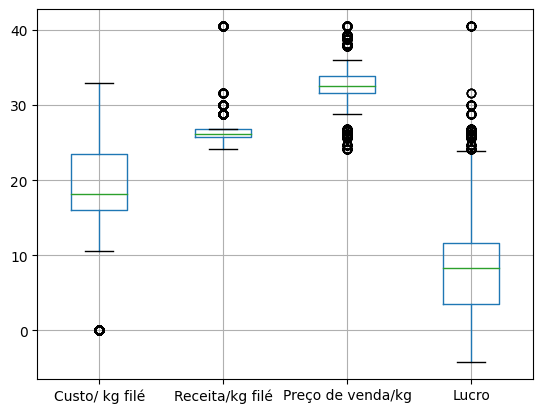

In [ ]:
boxplot3 = ind.boxplot(column=[
'Custo/ kg filé',
'Receita/kg filé',
'Preço de venda/kg',
'Lucro'])
boxplot3.plot()

plt.show()

<Axes: >

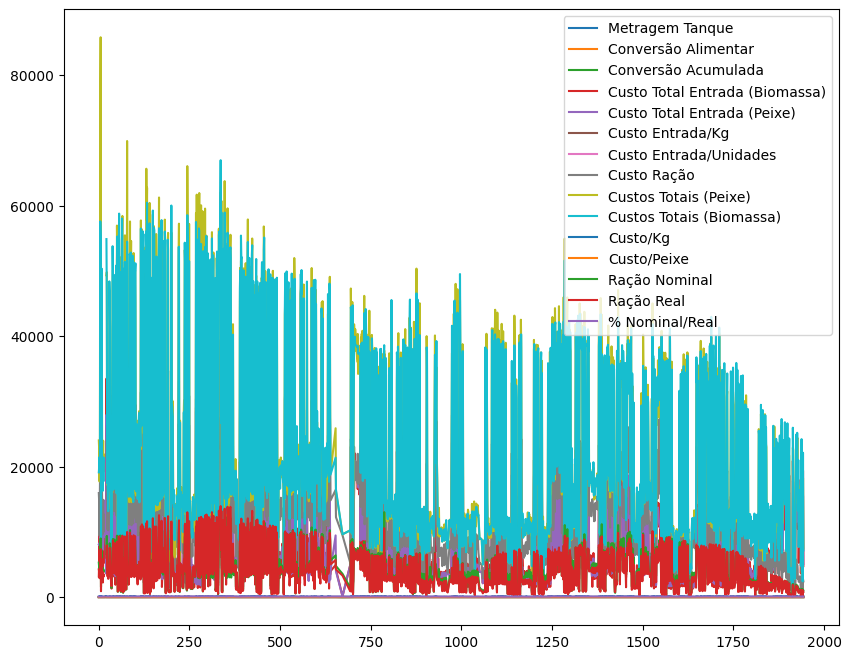

In [ ]:
prod_num2.plot( figsize = (10,8))